In [1]:
from klab.klab import Klab
from klab.geometry import GeometryBuilder
from klab.observable import Observable
from klab.utils import Export, ExportFormat
import asyncio
import os

In [4]:
STANDARD_PATH = os.path.join(os.path.expanduser('~'), ".klab", "testcredentials.properties")
async def ARIES_request(klab: Klab, area_WKT: str, obs_res: str, obs_year: int, observable: str,
                        export_format: ExportFormat, export_path: str):
    """to warp the ARIES request to trigger the asyncio ticket handling

    :param klab: active k.lab client instance
    :param area_WKT: geometry to use a context, here defined by WKT string
    :param obs_res: spatial resolution of the context
    :param obs_year: temporal domain (here only single years allowed)
    :param observable: observable - semantic syntax for requested dataset/model
    :param export_format: export format for the retrieved data
    :param export_path: absolute file path to save data to
    """
    # create the semantic type and geometry/time to init the CONTEXT
    obs = Observable.create("earth:Region")
    grid = GeometryBuilder().grid(urn=area_WKT, resolution=obs_res).years(obs_year).build()

    # submit to engine to generate the CONTEXT
    ticketHandler = klab.submit(obs, grid)
    context = await ticketHandler.get()

    # define the observable (dataset or model) and submit to context
    obsData = Observable.create(observable)
    ticketHandler = context.submit(obsData)
    data = await ticketHandler.get()

    # retrieve the dataset and export to disk
    data.exportToFile(Export.DATA, export_format, export_path)

def get_klab_instance(fpath: str = STANDARD_PATH) -> Klab:
    """initialization of the klab RemoteEngine object with fallback to LocalEngine

    :param fpath: absolute file path to the k.HUB credential properties file
    :return: active k.LAB client instance
    """
    try:
        print('- try Remote Engine connection ....')
        klab = Klab.create(credentialsFile=fpath)
    except:
        try:
            print('- try Local Engine connection ...')
            klab = Klab.create()
        except:
            raise RuntimeError('Could not establish connection to a k.lab engine')

    if klab and klab.isOnline():
        print(f'* connection to {klab.engine.url} was successfully established. session: {klab.engine.session}')
    else:
        raise EnvironmentError('could not establish connection to the klab instance')

    return klab

In [5]:
# create a new klab client instance -> use own credential file
klab = get_klab_instance(os.path.join(os.path.expanduser('~'), "aries_client_credentials.properties"))

- try Remote Engine connection ....
* connection to https://developers.integratedmodelling.org/modeler was successfully established. session: st8p7h1p0ff


In [6]:
# init parameters
param = {
    'polygon_WKT': "EPSG:4326 POLYGON((33.796 -7.086, 35.946 -7.086, 35.946 -9.41, 33.796 -9.41, 33.796 -7.086))",
    'observable': "geography:Elevation",  # symantic syntax
    'observation_resolution': "1 km",  # must be a string with unit definition
    'observation_time': 2010,
    'export_format': ExportFormat.BYTESTREAM,  # for single file return
    'out_path': os.path.normpath(r'./elevation_test.tif')}

In [10]:
# some specific function to run asyncio in Jupyter
loop = asyncio.get_event_loop()

In [11]:
# now we can run the asyncio function and execute the data retrival
try:
    loop.create_task(ARIES_request(klab,
                              area_WKT=param['polygon_WKT'],
                              observable=param['observable'],
                              obs_res=param['observation_resolution'],
                              obs_year=param['observation_time'],
                              export_format=param['export_format'],
                              export_path=param['out_path']))
    print(f'{param["observable"]} dataset successfully retrieved. File saved: {param["out_path"]}')
except:
    raise RuntimeError('could not retrieve the data from ARIES')
finally:
    klab.close()

geography:Elevation dataset successfully retrieved. File saved: elevation_test.tif


C:\Users\BUCHHORM\Anaconda3\envs\people\lib\site-packages\attr\_make.py:301: RuntimeWarning: coroutine 'ARIES_request' was never awaited
  bytecode = compile(script, filename, "exec")


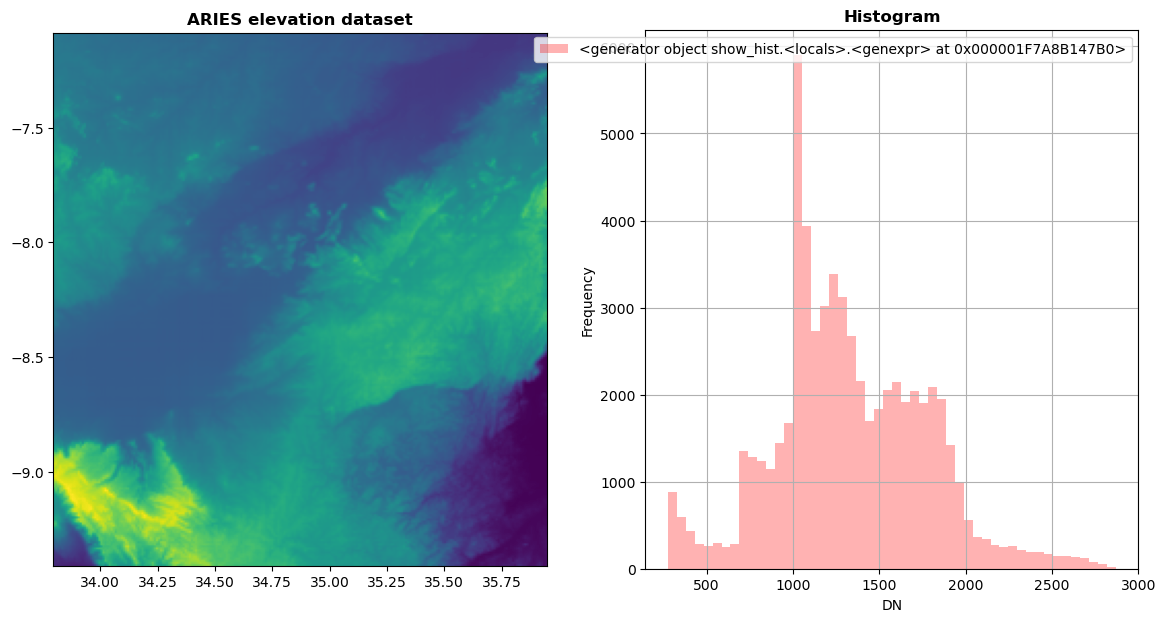

In [12]:
import rasterio
from rasterio.plot import show, show_hist
from matplotlib import pyplot
# visu result
with rasterio.open("elevation_test.tif") as src:
    fig, (axrgb, axhist) = pyplot.subplots(1, 2, figsize=(14,7))
    show(src, with_bounds=True, ax=axrgb, title='ARIES elevation dataset')
    show_hist(src, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histogram", ax=axhist)
    pyplot.show()